In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

import joblib

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [3]:
processed_path = Path("../data/processed")

df_model = pd.read_csv(processed_path / "lendingclub_clean.csv")

df_model.shape, df_model["default"].mean()

((1373915, 31), np.float64(0.21484298519195147))

In [4]:
cfg = joblib.load(processed_path / "preprocessor.joblib")
numeric_cols = cfg["numeric_cols"]
categorical_cols = cfg["categorical_cols"]
target_col = cfg["target_col"]

len(numeric_cols), len(categorical_cols), target_col


(21, 8, 'default')

In [5]:
X = df_model[categorical_cols + numeric_cols]
y = df_model[target_col].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp,
)

X_train.shape, X_val.shape, X_test.shape


((961740, 29), (206087, 29), (206088, 29))

In [6]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)


(default
 0    0.785157
 1    0.214843
 Name: proportion, dtype: float64,
 default
 0    0.785159
 1    0.214841
 Name: proportion, dtype: float64,
 default
 0    0.785155
 1    0.214845
 Name: proportion, dtype: float64)

In [7]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

X_train_proc.shape, X_val_proc.shape, X_test_proc.shape


((961740, 141), (206087, 141), (206088, 141))

In [8]:
X_train_dense = X_train_proc.toarray().astype(np.float32)
X_val_dense = X_val_proc.toarray().astype(np.float32)
X_test_dense = X_test_proc.toarray().astype(np.float32)

y_train_np = y_train.to_numpy().astype(np.float32)
y_val_np = y_val.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.float32)

X_train_dense.shape, X_val_dense.shape, X_test_dense.shape


((961740, 141), (206087, 141), (206088, 141))

In [9]:
joblib.dump(
    {
        "preprocessor": preprocessor,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "target_col": target_col,
    },
    processed_path / "preprocessor.joblib",
)


['..\\data\\processed\\preprocessor.joblib']

In [10]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.tensor(self.y[idx]),
        )

input_dim = X_train_dense.shape[1]
input_dim


141

In [11]:
batch_size = 4096

train_ds = NumpyDataset(X_train_dense, y_train_np)
val_ds = NumpyDataset(X_val_dense, y_val_np)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=batch_size * 2, shuffle=False, num_workers=0)


In [12]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [13]:
model = MLP(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [14]:
def evaluate(model, X, y, batch_size=8192):
    model.eval()
    all_logits = []

    with torch.no_grad():
        for start in range(0, X.shape[0], batch_size):
            xb = torch.from_numpy(X[start:start + batch_size]).to(device)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())

    logits = np.concatenate(all_logits)
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)

    return {
        "auc": roc_auc_score(y, probs),
        "f1": f1_score(y, preds),
        "acc": accuracy_score(y, preds),
    }


In [15]:
n_epochs = 8

best_val_auc = 0.0
best_state_dict = None

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1)
    val_metrics = evaluate(model, X_val_dense, y_val_np)

    print(
        f"Epoch {epoch:02d} "
        f"train_loss={train_loss:.4f} "
        f"val_auc={val_metrics['auc']:.4f} "
        f"val_f1={val_metrics['f1']:.4f} "
        f"val_acc={val_metrics['acc']:.4f}"
    )

    if val_metrics["auc"] > best_val_auc:
        best_val_auc = val_metrics["auc"]
        best_state_dict = model.state_dict()


Epoch 01 train_loss=0.4792 val_auc=0.7250 val_f1=0.1886 val_acc=0.7916
Epoch 02 train_loss=0.4658 val_auc=0.7287 val_f1=0.2071 val_acc=0.7926
Epoch 03 train_loss=0.4638 val_auc=0.7310 val_f1=0.2052 val_acc=0.7930
Epoch 04 train_loss=0.4628 val_auc=0.7322 val_f1=0.2262 val_acc=0.7931
Epoch 05 train_loss=0.4620 val_auc=0.7331 val_f1=0.2238 val_acc=0.7934
Epoch 06 train_loss=0.4614 val_auc=0.7334 val_f1=0.2220 val_acc=0.7939
Epoch 07 train_loss=0.4609 val_auc=0.7340 val_f1=0.2256 val_acc=0.7936
Epoch 08 train_loss=0.4607 val_auc=0.7344 val_f1=0.2257 val_acc=0.7938


In [16]:
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

val_metrics = evaluate(model, X_val_dense, y_val_np)
test_metrics = evaluate(model, X_test_dense, y_test_np)

val_metrics, test_metrics


({'auc': 0.7343613237911604,
  'f1': 0.2256636361980068,
  'acc': 0.793771562495451},
 {'auc': 0.7319562578886192,
  'f1': 0.22479802023436932,
  'acc': 0.793282481270137})

In [17]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

model.eval()
with torch.no_grad():
    logits_val = model(torch.from_numpy(X_val_dense).to(device))
    probs_val = torch.sigmoid(logits_val).cpu().numpy().ravel()

precision, recall, thresholds = precision_recall_curve(y_val_np, probs_val)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 threshold on validation: {best_threshold:.4f}")
print(f"Best F1 on validation: {best_f1:.4f}")

model.eval()
with torch.no_grad():
    logits_test = model(torch.from_numpy(X_test_dense).to(device))
    probs_test = torch.sigmoid(logits_test).cpu().numpy().ravel()

y_test_pred_best = (probs_test >= best_threshold).astype("int64")

print("\nConfusion matrix on test at best F1 threshold:")
cm = confusion_matrix(y_test_np, y_test_pred_best)
print(cm)

print("\nClassification report on test at best F1 threshold:")
print(classification_report(y_test_np, y_test_pred_best, digits=3))


Best F1 threshold on validation: 0.2285
Best F1 on validation: 0.4673

Confusion matrix on test at best F1 threshold:
[[113462  48349]
 [ 16255  28022]]

Classification report on test at best F1 threshold:
              precision    recall  f1-score   support

         0.0      0.875     0.701     0.778    161811
         1.0      0.367     0.633     0.465     44277

    accuracy                          0.687    206088
   macro avg      0.621     0.667     0.621    206088
weighted avg      0.766     0.687     0.711    206088



In [17]:
model_path = processed_path / "mlp_supervised.pth"

torch.save(
    {
        "state_dict": model.state_dict(),
        "input_dim": input_dim,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "target_col": target_col,
    },
    model_path,
)

model_path


WindowsPath('../data/processed/mlp_supervised.pth')

In [18]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

y_test_np = y_test.values
y_pred_zero = np.zeros_like(y_test_np)

print("Always-non-default baseline:")
print("acc =", accuracy_score(y_test_np, y_pred_zero))
print("f1  =", f1_score(y_test_np, y_pred_zero, zero_division=0))
print("auc =", roc_auc_score(y_test_np, y_pred_zero))


Always-non-default baseline:
acc = 0.7851548852917201
f1  = 0.0
auc = 0.5


In [19]:
print("Validation:", val_metrics)
print("Test:", test_metrics)


Validation: {'auc': 0.7341861692998735, 'f1': 0.24876572702659658, 'acc': 0.7940044738387186}
Test: {'auc': 0.7321154686641006, 'f1': 0.2473454532605431, 'acc': 0.7932873335662436}


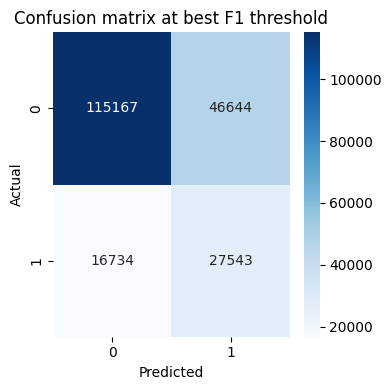

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix at best F1 threshold")
plt.tight_layout()
plt.show()
